In [1]:
!pip install spacy unidecode
!python -m spacy download es_core_news_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 48.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import re
import spacy
from unidecode import unidecode
from tqdm import tqdm

nlp = spacy.load("es_core_news_sm")

In [5]:
# Omdena (sí tiene 'Corrected_label')
dfo = pd.read_csv("/content/drive/MyDrive/MCD Folder/2025-1/AAA/De A Mentis/deamentis-fakenews/data/raw/omdena/fake_news_latam_omdena_combined.csv")
dfo = dfo[["Text", "Corrected_label"]].dropna()
dfo = dfo.rename(columns={"Corrected_label": "label"})

# Posadas (tiene 'Category' en lugar de 'Corrected_label')
dfp = pd.read_csv("/content/drive/MyDrive/MCD Folder/2025-1/AAA/De A Mentis/deamentis-fakenews/data/raw/FakeNewsCorpusSpanish/fake_news_corpus_posadas_full.csv")
dfp = dfp[["Text", "Category"]].dropna()
dfp = dfp.rename(columns={"Category": "label"})



In [6]:
def extract_features(text):
    doc = nlp(str(text))
    n_tokens = len([t for t in doc if not t.is_punct and not t.is_space])
    n_sentences = len(list(doc.sents))
    avg_token_length = sum(len(t.text) for t in doc if t.is_alpha) / (len([t for t in doc if t.is_alpha]) + 1e-6)

    ents = [ent.label_ for ent in doc.ents]
    n_ents = len(ents)
    n_PER = ents.count("PER")
    n_ORG = ents.count("ORG")
    n_LOC = ents.count("LOC")

    n_quotes = len(re.findall(r'"[^"]+"', str(text)))
    has_quotes = int(n_quotes > 0)
    n_numbers = len(re.findall(r'\b\d+(\.\d+)?\b', str(text)))
    n_uppercase_words = len([w for w in str(text).split() if w.isupper() and len(w) > 1])

    return pd.Series({
        "n_tokens": n_tokens,
        "n_sentences": n_sentences,
        "avg_token_length": avg_token_length,
        "n_named_entities": n_ents,
        "n_entities_PER": n_PER,
        "n_entities_ORG": n_ORG,
        "n_entities_LOC": n_LOC,
        "has_quotes": has_quotes,
        "n_quotes": n_quotes,
        "n_numbers": n_numbers,
        "n_uppercase_words": n_uppercase_words
    })

In [7]:
tqdm.pandas()

# Omdena
features_omdena = dfo["Text"].progress_apply(extract_features)
dfo_features = pd.concat([dfo.reset_index(drop=True), features_omdena], axis=1)

# Posadas
features_posadas = dfp["Text"].progress_apply(extract_features)
dfp_features = pd.concat([dfp.reset_index(drop=True), features_posadas], axis=1)


100%|██████████| 971/971 [01:12<00:00, 13.36it/s]


In [8]:
print("📊 Estadísticas Omdena")
print(dfo_features.groupby("label").mean(numeric_only=True))

print("\n📊 Estadísticas Posadas")
print(dfp_features.groupby("label").mean(numeric_only=True))


📊 Estadísticas Omdena
         n_tokens  n_sentences  avg_token_length  n_named_entities  \
label                                                                
Fake   134.704501     5.140900          5.273813         12.705479   
True   169.378261     6.218357          5.236972         15.512560   

       n_entities_PER  n_entities_ORG  n_entities_LOC  has_quotes  n_quotes  \
label                                                                         
Fake         3.613503        2.417808        3.080235    0.171233  0.410959   
True         4.204831        3.094203        4.119807    0.195169  0.552657   

       n_numbers  n_uppercase_words  
label                                
Fake    2.280822           1.986301  
True    3.447343           2.756039  

📊 Estadísticas Posadas
         n_tokens  n_sentences  avg_token_length  n_named_entities  \
label                                                                
Fake   295.174556     9.047337          4.816792         20.6390

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def compare_feature(feature, dataset1, dataset2, name1="Omdena", name2="Posadas"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    sns.boxplot(data=dataset1, x="label", y=feature, ax=axes[0])
    axes[0].set_title(f"{feature} - {name1}")

    sns.boxplot(data=dataset2, x="label", y=feature, ax=axes[1])
    axes[1].set_title(f"{feature} - {name2}")

    plt.suptitle(f"Comparación de {feature} entre datasets")
    plt.show()


In [12]:
# Verifica que estas columnas existan
print(dfo.columns)
print(dfp.columns)


Index(['Text', 'label'], dtype='object')
Index(['Text', 'label'], dtype='object')


In [13]:
# Verifica que estas columnas existan
print(dfo_features.columns)
print(dfp_features.columns)


Index(['Text', 'label', 'n_tokens', 'n_sentences', 'avg_token_length',
       'n_named_entities', 'n_entities_PER', 'n_entities_ORG',
       'n_entities_LOC', 'has_quotes', 'n_quotes', 'n_numbers',
       'n_uppercase_words'],
      dtype='object')
Index(['Text', 'label', 'n_tokens', 'n_sentences', 'avg_token_length',
       'n_named_entities', 'n_entities_PER', 'n_entities_ORG',
       'n_entities_LOC', 'has_quotes', 'n_quotes', 'n_numbers',
       'n_uppercase_words'],
      dtype='object')


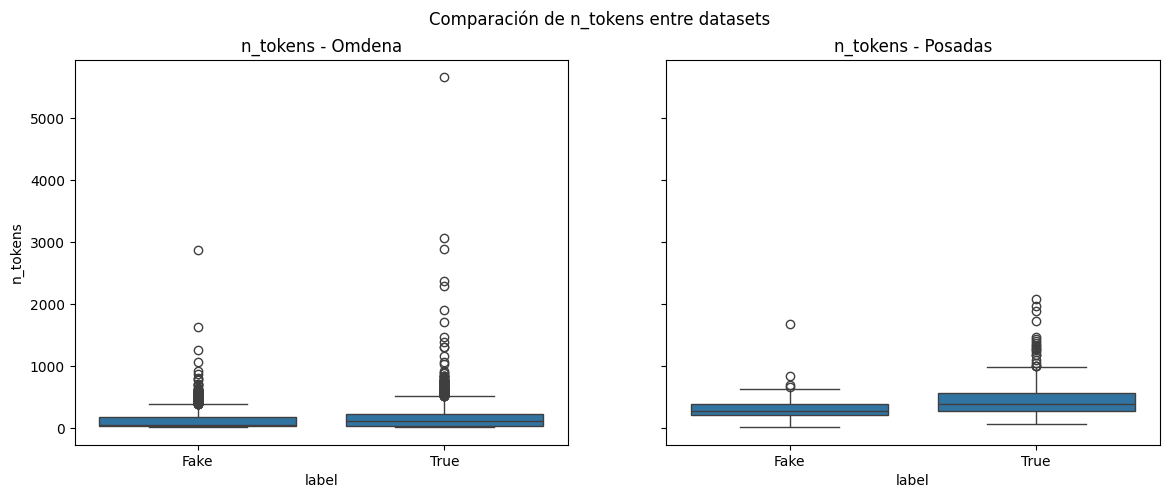

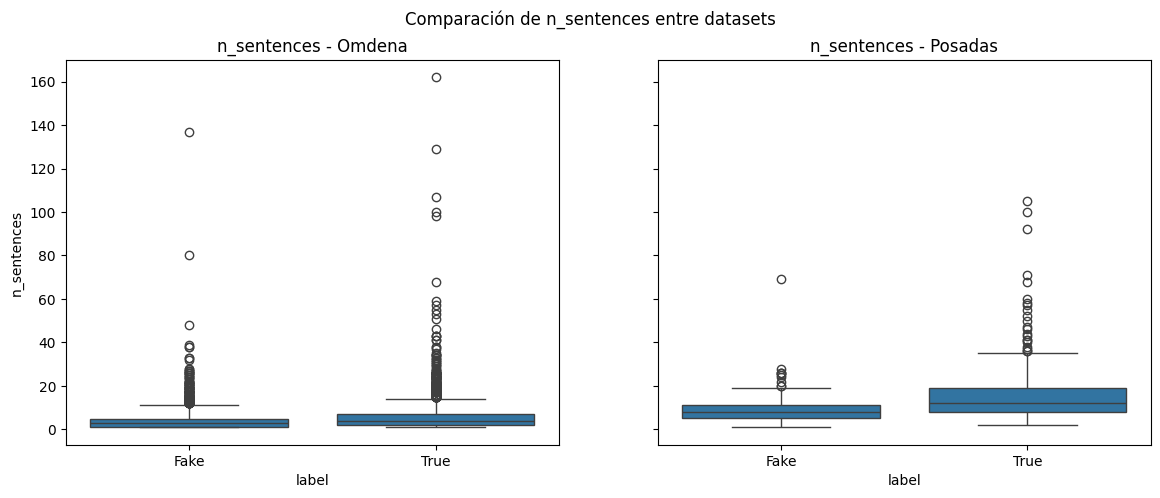

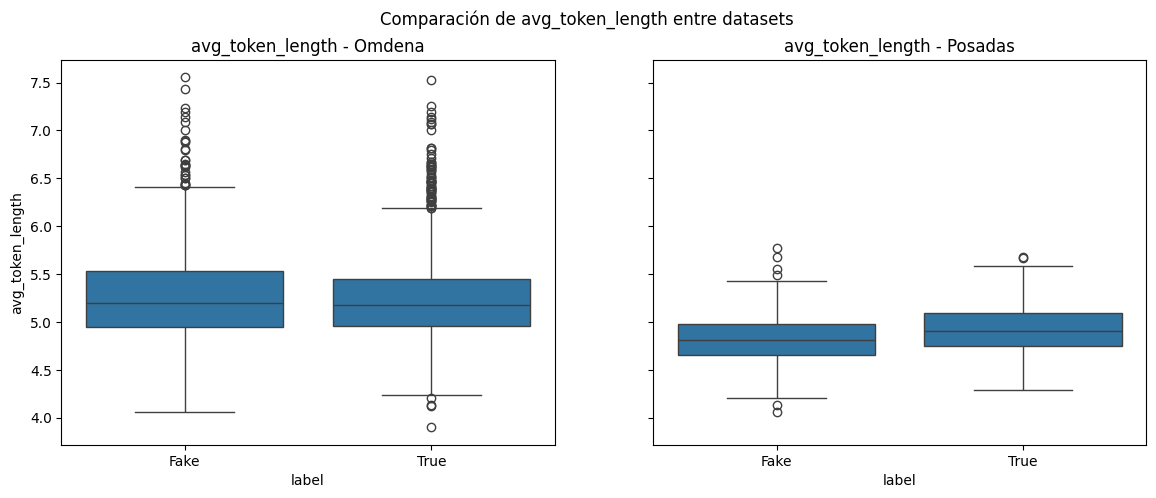

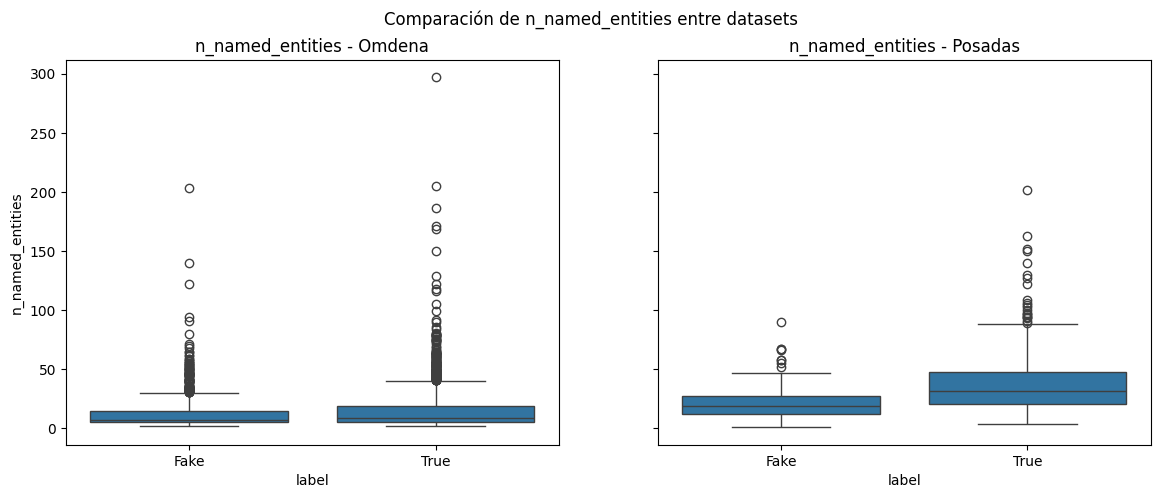

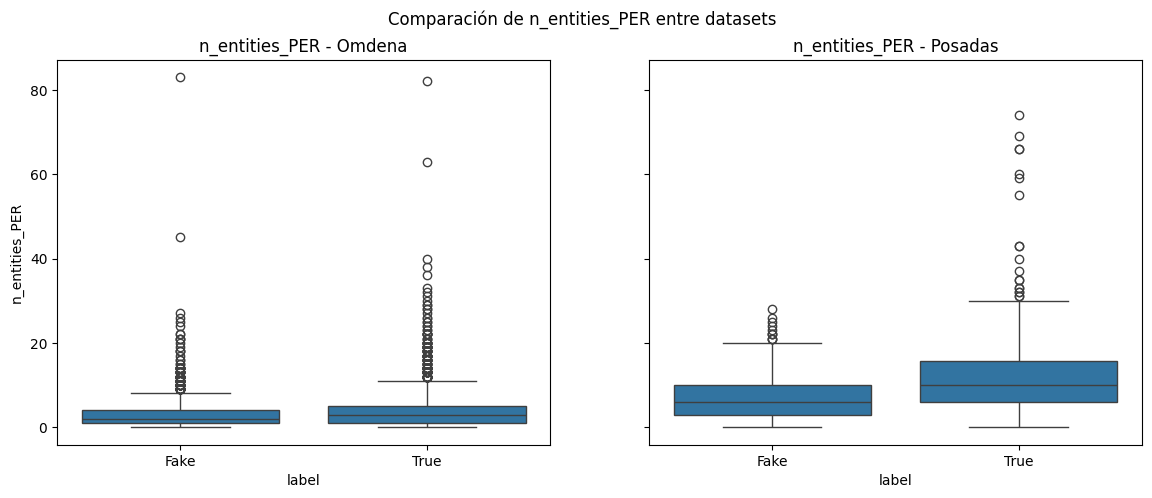

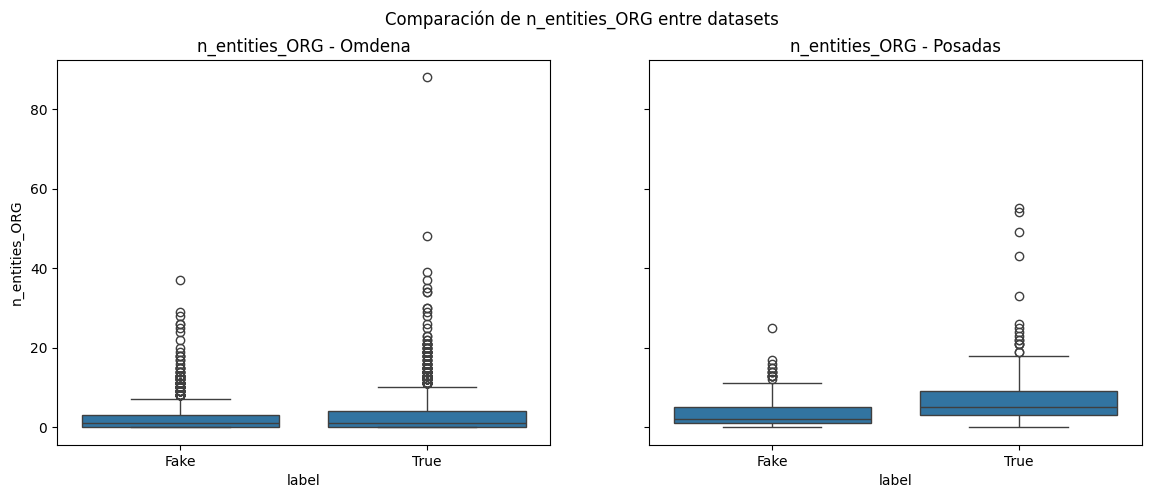

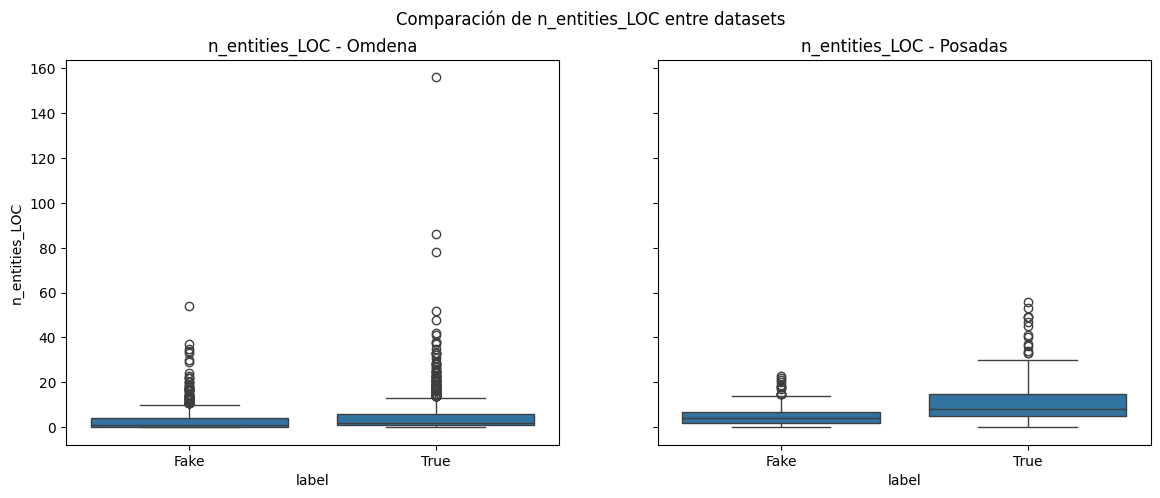

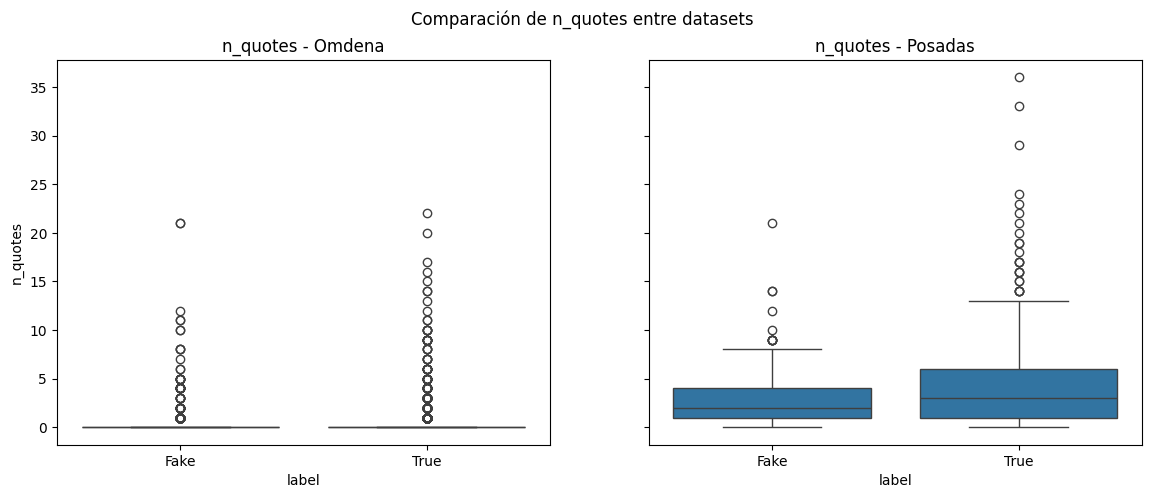

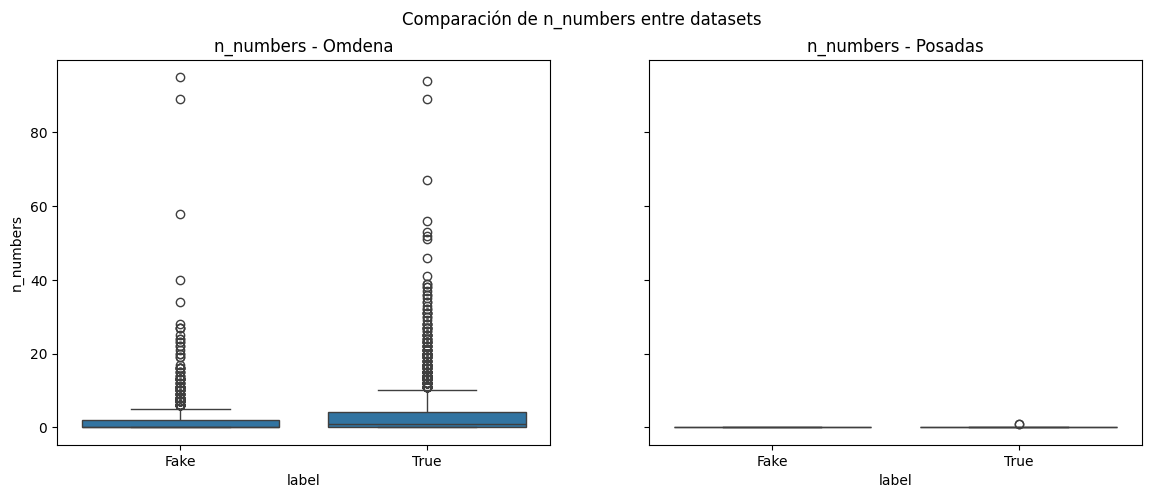

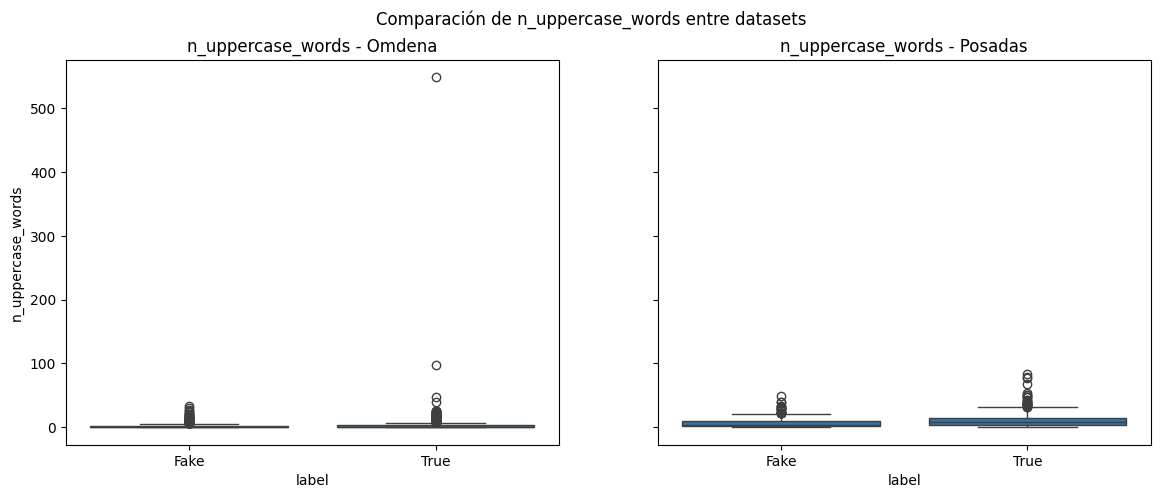

In [14]:
features_to_plot = [
    "n_tokens",
    "n_sentences",
    "avg_token_length",
    "n_named_entities",
    "n_entities_PER",
    "n_entities_ORG",
    "n_entities_LOC",
    "n_quotes",
    "n_numbers",
    "n_uppercase_words"
]

for feature in features_to_plot:
    compare_feature(feature, dfo_features, dfp_features)


Tenemos las estadísticas por clase para ambos datasets con las nuevas features extraídas.

---

## 🧠 Comparación de Features por Clase (Omdena vs Posadas)

| Feature | Omdena Fake | Omdena True | Posadas Fake | Posadas True | Observaciones |
|--------|--------------|--------------|----------------|----------------|----------------|
| `n_tokens` | 135 | 169 | 295 | 460 | 📈 Posadas tiene textos más largos |
| `n_sentences` | 5.1 | 6.2 | 9.0 | 16.0 | ✅ Omdena: frases más cortas y simples |
| `avg_token_length` | 5.27 | 5.24 | 4.82 | 4.93 | 🧠 Omdena usa palabras más largas |
| `n_named_entities` | 12.7 | 15.5 | 20.6 | 39.1 | 📊 Posadas tiene más menciones de entidades |
| `n_entities_PER` | 3.6 | 4.2 | 7.1 | 12.6 | ✅ En ambos datasets, los textos verdaderos mencionan más personas |
| `n_entities_ORG` | 2.4 | 3.1 | 3.3 | 7.0 | 🔍 Mismo patrón con organizaciones |
| `n_entities_LOC` | 3.1 | 4.1 | 5.2 | 11.2 | 🌍 Noticias verdaderas mencionan más lugares |
| `has_quotes` | 17% | 20% | 83% | 80% | 🤯 En Posadas, casi todas las noticias tienen citas |
| `n_quotes` | 0.41 | 0.55 | 3.09 | 4.40 | 🗣️ Las verdaderas citan más, pero las falsas también lo hacen |
| `n_numbers` | 2.28 | 3.45 | 0.00 | 0.006 | 📉 En Posadas, no hay cifras casi en absoluto |
| `n_uppercase_words` | 1.99 | 2.76 | 6.7 | 11.9 | 🔊 ¡Posadas tiene muchas más palabras en mayúsculas! (posible sensacionalismo) |

---

## 🎯 Implicaciones para Modelado

### ✅ Features que podrían ser más predictivos:
- `n_named_entities`, `n_entities_*` → más alto en verdaderas
- `n_quotes` → mayor en verdaderas
- `n_uppercase_words` → alto en Posadas, posible discriminante
- `n_numbers` → útil en Omdena, **no en Posadas**

